$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Im}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}} 
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$

# ML Methodology 


### Spring 2019

### Minwoo "Jake" Lee

# Today

- Polynomial Regression for Nonlinearity
- Generalization
- Bias-Variance Tradeoff
- Regularization
- CV

# Review: Classification Measures



- Accuracy

- Confusion Matrix

- Precision, Recall, and Specificity

- F1-Score

- MCC 

- ROC and AUC

- PR (Precision-Recall) Curvecv

> "You should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise."

In [14]:
###############################################
# Perceptron classifier
def train_perceptron(X, T, **params):
    maxiter = params.pop('maxiter', 1000)
    alpha = params.pop('alpha', 0.1)
    init = params.pop('init', "rand")
    bverbose = params.pop('verbose', False)
    
    if init == 'zero':
        w = np.zeros(X.shape[1])
    else:
        w = np.random.rand(X.shape[1]) 

    for i in range(maxiter):
        converged = True
        for k in range(N):
            y = w @ X[k]
            if np.sign(y) != np.sign(T[k]):
                w += alpha * T[k] * X[k]
                converged = False

        if converged:
            if bverbose: print("converged at ", i)
            break
    if bverbose: 
        print("End of training: ", i)
    return w

def predict_linear(X, w):
    return X @ w


###############################################
# ROC and PR
def roc_pr(Y, T):
    fprs = []
    tprs = []
    pres = []
    recs = []
    #sorted_i = np.argsort(Y)

    for thres in sorted(Y)[::-1]:

        n_TP = np.logical_and( Y >= thres, T == 1).sum()
        n_FP = np.logical_and( Y >= thres, T == -1).sum()
        n_TN = np.logical_and( Y < thres, T == -1).sum()
        n_FN = np.logical_and( Y < thres, T == 1).sum()

        #print(n_TP, n_FP, n_TN, n_FN)

        fpr = n_FP / (n_FP + n_TN) 
        tpr = n_TP / (n_TP + n_FN) 
        fprs.append(fpr)
        tprs.append(tpr)
        precision = n_TP / (n_TP + n_FP) 
        recall = n_TP / (n_TP + n_FN)
        pres.append(precision)
        recs.append(recall)
    
    return fprs, tprs, recs, pres


def roc_curve(fprs, tprs):
    plt.plot(fprs, tprs)
    plt.xlabel("P(FP)")
    plt.ylabel("P(TP)")
    
def pr_curve(recs, pres):
    plt.plot(recs, pres)
    plt.xlabel("Recall")
    plt.ylabel("Precesion")  
    
    

###############################################
# sample data
    
nC1 = 180
nC2 = 20       ########## <------- smaller class 2!
N = nC1 + nC2

# Example data
mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 10

C1 = np.random.multivariate_normal(mu1, cov1, nC1)
C2 = np.random.multivariate_normal(mu2, cov2, nC2)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])

X = np.vstack((C1, C2))
T = np.ones(N)
T[:nC1] *= -1 


###############################################
# train the model
perceptron = train_perceptron(X, T, maxiter=100, alpha=0.1, verbose=True)
Y = predict_linear(X, perceptron)

plt.plot(T)
plt.plot(Y)


###############################################
# plot ROC and PR Curves
measures = roc_pr(Y, T)
plt.figure(figsize=(10,5))
plt.subplot(121)
roc_curve(*measures[:2])
plt.title("ROC Curve")
plt.subplot(122)
pr_curve(*measures[2:])
plt.title("PR Curve")


End of training:  99


# Review: Regression Measures



- mean absolute error (MAE) = $\frac{1}{N} \sum \vert t - y \vert$
  - simple & intuitive sum of residuals

- mean squared error (MSE) = $\frac{1}{N} \sum (t - y)^2$
  - outliers are highly penalized than MAE
  - why RMSE?

- mean absolute percentage error (MAPE) = $\frac{100 \%}{N} \sum \vert \frac{t - y}{t} \vert$
  - scaling with the actual target values
  - biased towards less values than target

- mean percentage error (MAPE) = $\frac{100 \%}{N} \sum \big( \frac{t - y}{t} \big)$
  - absence of absolute values: not good estimation of overall performance
  - tells us if a model **underestimates** or **overestimates** (systematic errors)

- R-squared ($R^2$) error = $1 - \frac{\text{Variation of Erros (residuals)}}{\text{Total Variation}} = 1 - \frac{\sum_i (y_i - t_i)^2}{\sum_i (y_i - \bar{y})^2}$
  - comparison of varirances
  - how to read? - 100% means the model explains all the variability of the response around the mean

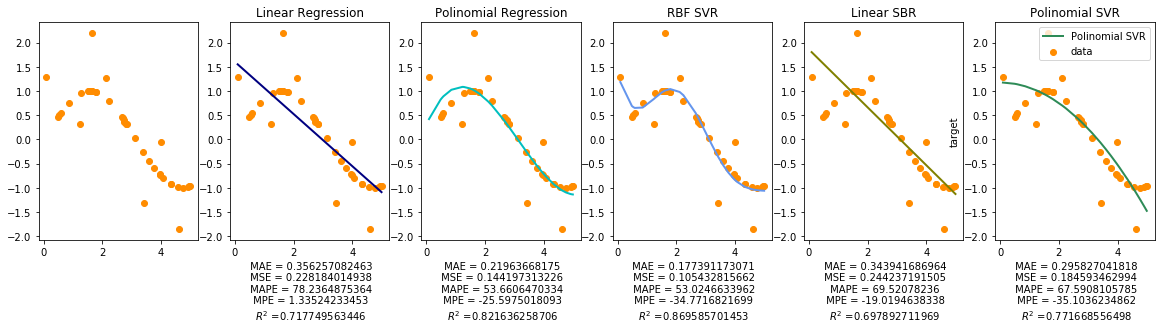

In [12]:
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
t = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
t[::5] += 3 * (0.5 - np.random.rand(8))


names = ["Linear Regression", "Polinomial Regression", "RBF SVR", 
         "Linear SBR", "Polinomial SVR"]
colors = ["navy", "c", "cornflowerblue", "olive", "seagreen"]

# #############################################################################
# Regression models
regressors = [
    LinearRegression(),
    Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))]),
    SVR(kernel='rbf', C=1e3, gamma=0.1),
    SVR(kernel='linear', C=1e3),
    SVR(kernel='poly', C=1e3, degree=2)
]

i = 1

plt.figure(figsize=(20,4))
plt.subplot(1, len(regressors) + 1, i)
plt.scatter(X, t, color='darkorange', label='data')
lw = 2

for name, color, regr in zip(names, colors, regressors):


    # #############################################################################
    # Fit regression model
    regr.fit(X, t)
    # #############################################################################
    # Prediction
    y = regr.predict(X)
v
    # #############################################################################
    # Look at the results
    i += 1
    plt.subplot(1, len(regressors) + 1, i)
    plt.scatter(X, t, color='darkorange', label='data')
    plt.plot(X, y, color=color, lw=lw, label=name)
    
    # #############################################################################
    # Regression Measures
    MAE = np.mean(np.abs(t-y))
    MSE = np.mean((t-y)**2)
    MAPE = 100 * np.mean(np.abs((t-y)/t))
    MPE = 100 * np.mean((t-y)/t)
    R2 = 1 - np.sum((y-t)**2) / np.sum((t - np.mean(t))**2)
    #print("R2 = ", R2)
    s_title =   " MAE = " + str(MAE) +\
                "\n MSE = " + str(MSE) +\
                "\n MAPE = " + str(MAPE) +\
                "\n MPE = " + str(MPE) +\
                "\n $R^2$ =" + str(R2)
    plt.title(name)
    plt.xlabel(s_title)
plt.ylabel('target')
plt.legend()
plt.show()

# Review: Clustering Measures

* With GT
  * Adjusted Rand Index (ARI), Normalized Mutual Information (NMI), Adjusted Mutual Information (AMI)
  * Homogeneity and completeness, V-measure

* Without GT
  * Sihouette Score
  * Calinski-Harabaz Index

For more, https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

# Learning Curve

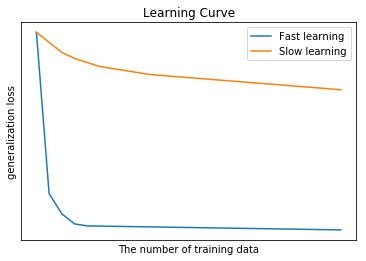

# Polynomial Regression


- Linear Model

$$ f(\xv; \wv) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 $$


- Polynomial 

$$ f(\xv; \wv) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 +  w_4 x_1^2 + w_5 x_2^2 + w_6 x_3^2 +  w_7 x_1^3 + w_8 x_2^3 + w_9 x_3^3 + \cdots $$


In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy as copy

# Polinomial regression
def poly_regress(x, d=3, t=None, **params):
    bnorm = params.pop('normalize', False)
    
    X_poly = []
    # append polynomial terms
    for i in range(d+1):
        X_poly.append(x**i)
    
    X_poly = np.vstack(X_poly).T
    
    # normalize 
    if bnorm:
        mu, sd = np.mean(X_poly[:, 1:, None], axis=0), np.std(X_poly[:, 1:, None], axis=0)
        X_poly[:, 1:] = (X_poly[:, 1:] - mu.flat) / sd.flat
        
    # least sqaures
    if t is not None:
        w = np.linalg.lstsq(X_poly.T @ X_poly, X_poly.T @ t)[0]
        
        if bnorm:
            return X_poly, mu, sd, w
        return X_poly, w
    
    if bnorm:
        return X_poly, mu, sd
    return X_poly


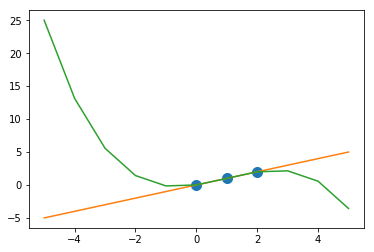

In [27]:
# training points
x = np.arange(3)
t = copy(x)

# scatter plot
def plot_data():
    plt.plot(x, t, "o", markersize=10)

    
# Training two models
_, wp = poly_regress(x, 3, t)
_, w  = poly_regress(x, 1, t)
    
# Test data
xtest = np.arange(11)-5
Xtest = poly_regress(xtest, 1)
Xptest = poly_regress(xtest, 3)
yptest = Xptest @ wp
ytest = Xtest @ w

plot_data()
plt.plot(xtest, ytest)
plt.plot(xtest, yptest)

In [29]:
!curl https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/lifesat/oecd_bli_2015.csv > oecd_bli_2015.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  395k  100  395k    0     0   523k      0 --:--:-- --:--:-- --:--:--  556k


In [31]:
!curl https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/lifesat/gdp_per_capita.csv > gdp_per_capita.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36323  100 36323    0     0  77914      0 --:--:-- --:--:-- --:--:-- 81624


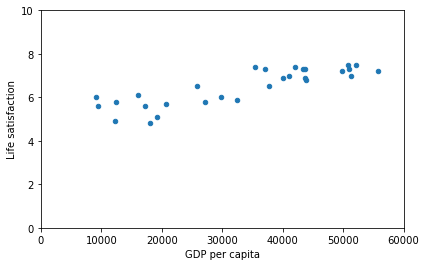

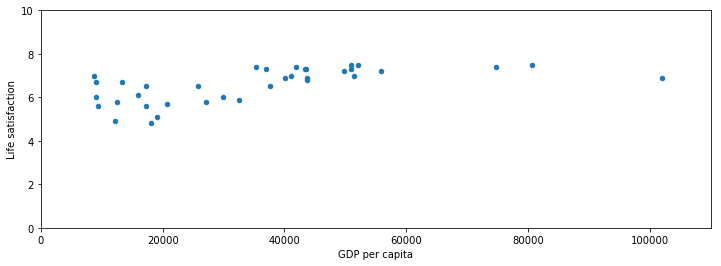

In [34]:
import os
import pandas as pd
import sklearn

def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices], full_country_stats[["GDP per capita", 'Life satisfaction']]
    

# Load the data
oecd_bli = pd.read_csv("oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv("gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")


# Prepare the data
country_stats, full_country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(6.5,4))
plt.axis([0, 60000, 0, 10])
plt.show()


# Data for training
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]

# Visualize the full data
# Visualize the data
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(12,4))
plt.axis([0, 110000, 0, 10])
plt.show()


In [37]:
# polynomial model to this data

def fit_poly(deg):
    plt.figure();
    full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction',
                            figsize=(12,4));
    plt.axis([0, 110000, 3, 10]);
    Xp, mu, sd, wp = poly_regress(Xfull.flatten(), deg, yfull.flatten(), normalize=True)
    yp1 = Xp @ wp

    # plot curve 
    plt.plot(Xfull, yp1, 'r-', label=deg);
    plt.title("degree: {}".format(deg));



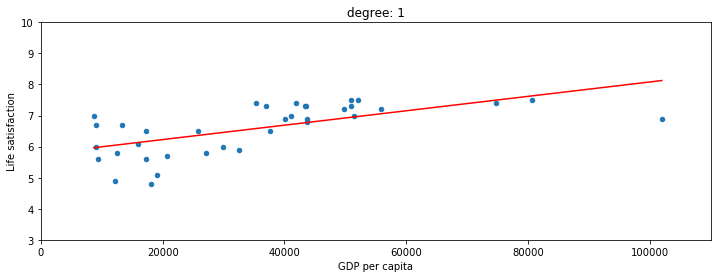

In [38]:
fit_poly(1)

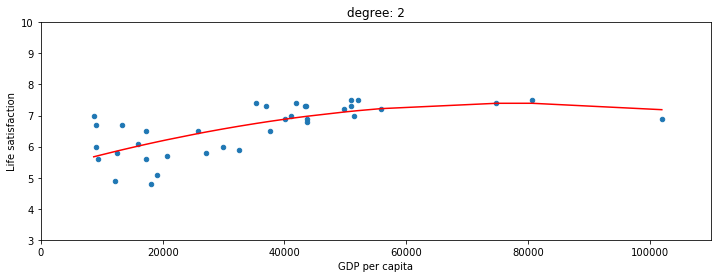

In [39]:
fit_poly(2)

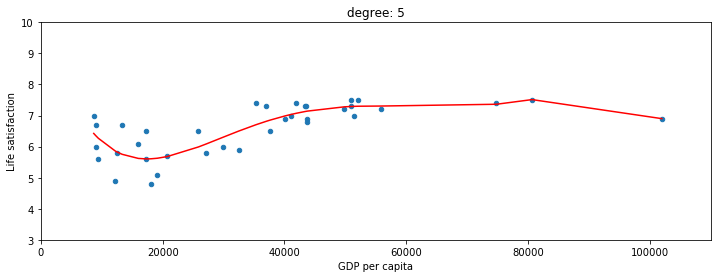

In [40]:
fit_poly(5)

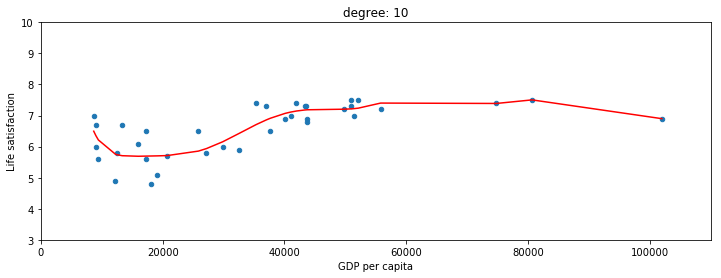

In [41]:
fit_poly(10)

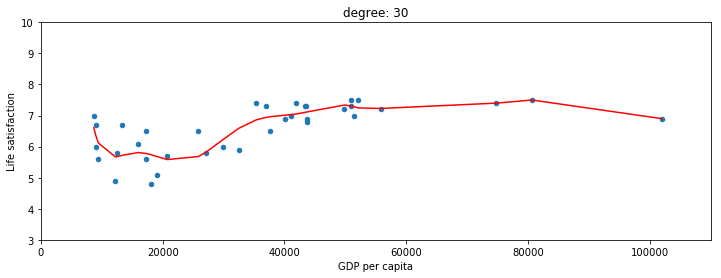

In [42]:
fit_poly(30)

# Overfitting


* learned hypothesis $h$
* hypothesis from another model $h^\prime$

$$ E_{train}(h) < E_{train}(h^\prime) \wedge E_{test}(h) > E_{test}(h^\prime).$$


# Bias-Variance Tradeoff


- high bias error: under-performing model that misses the important trends
- high variance error: excessively sensitive to small variations in the training data
- Irreducible error: genuine to the noise in the data. Need to clean up the data

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/bias-and-variance.jpg)
<center>From Understanding the Bias-Variance Tradeoff, by Scott Fortmann-Roe</center>

# Regularization



# Occam's razor

> entities must not be multiplied beyond necessity

<img width=500 src="https://hunter-iq.com/wp-content/uploads/sites/4/2016/09/hiqoccamsrazor.png"/>


# Regularization


* penalize on the over-complexity of a model

$$
\begin{align*}
E(\wv) &= \sum_i^N ( y_i - t_i)^2 + \lambda \lVert \wv \rVert_2^2  \\
  \\
  &= \sum_i^N ( y_i - t_i)^2 + \lambda \sum_k^D w_k^2 \\
  \\
  &= (\Xm \wv - T)^\top (\Xm \wv - T)  + \lambda \wv^\top \wv \\
  \\
  &= \wv^\top \Xm^\top \Xm \wv - 2 \Tm^\top \Xm \wv + \Tm^\top \Tm  + \lambda \wv^\top \wv 
\end{align*}
$$


# Regularization

$$
\begin{align*}
\frac{\partial E(\wv)}{\partial \wv} &= \frac{\partial (\Xm \wv - \Tm)^\top (\Xm \wv - \Tm)}{\partial \wv} + \frac{\partial \lambda \wv^\top \wv}{\partial \wv} \\
        \\
        &= 2 \Xm^\top \Xm \wv - 2 \Xm^\top \Tm + 2 \lambda \wv
\end{align*}
$$

# Regularization (Ridge Regression)

$$
\begin{align*}
 2 \Xm^\top \Xm \wv - 2 \Xm^\top \Tm  + 2 \lambda \wv = 0\\
\big(\Xm^\top \Xm + \lambda \Im \big) \wv = \Xm^\top \Tm\\
\wv = \big(\Xm^\top \Xm + \lambda \Im \big)^{-1} \Xm^\top \Tm.
\end{align*}
$$


# k-fold Cross Validation

>  Choose K for K-fold cross validation.

>  Set nfold = 0. 

>  Initialize the lists *res* = [], *testErrs* = [].

>  Split data X and label T into K number of partitions.

>  For each TEST partition 

>>  For each validation partition among the rest partitions 

>>>  Choose the rest partitions into a training set.

>>>  For each set __P__ of parameters to test

>>>>   Using __P__, train the model 

>>>>   Use the trained model on the validation data

>>>>   Evaluate the validation result and store the restuls to *res*

>>  From the *res* result, pick the one with the best result.

>>  Retrain the model with the best parameter __p__ in __P__.

>>  Apply the model with the best parameter __p*__ to the test dataset. 

>>  Evaluate the result *err* and store the tuple (__p*__, *err*) to *testErrs*. 

>  Return *testErrs*. 


# Feature Selection 

* Goal
  * Reduces overfitting
  * Improves accuracy
  * Reduces training time

# Feature Selection 

* Methods
  * Filter Methods
    - a statistical measure to score each feature
    - $\chi^2$-test, information gain, correlation coefficient scores
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/2c/Filter_Methode.png" width=600/>
  * Wrapper Methods
    - a search of a set of features
    - a predictive model to evaluate them
    <img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Feature_selection_Wrapper_Method.png" width=600/>
  * Embedded Methods
    - learn best features while the model is learning
    - regularization
    <img src="https://upload.wikimedia.org/wikipedia/commons/b/bf/Feature_selection_Embedded_Method.png" width=600/>

# Next

* Neural Networks